# Chapter 5. Textual Data
This notebook is complementary material to Chapter 5 of the thesis.

# Finnhub
- API version: 1.0.0
- Package version: 2.4.19
- API Documentation: https://finnhub.io/docs/api/company-news
- Finnhub's official python library: https://github.com/Finnhub-Stock-API/finnhub-python

## Company News
List latest company news by symbol. This endpoint is only available for North American companies.
Free plan allow us 1 year of historical news and new updates.

In [1]:
%pip install -q -r requirements.txt


[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
from dotenv import load_dotenv

load_dotenv()

# Contact me for the API key
FINNHUB_API_KEY = os.getenv("FINNHUB_API_KEY")

In [3]:
from datetime import datetime

YEAR = 2024

TICKERS = ["AAPL", "MSFT", "GOOGL", "AMZN"]

quarters = {
    "Q1": {"start": datetime(YEAR, 1, 1).date(), "end": datetime(YEAR, 3, 31).date()},
    "Q2": {"start": datetime(YEAR, 4, 1).date(), "end": datetime(YEAR, 6, 30).date()},
    "Q3": {"start": datetime(YEAR, 7, 1).date(), "end": datetime(YEAR, 9, 30).date()},
    "Q4": {"start": datetime(YEAR, 10, 1).date(), "end": datetime(YEAR, 12, 31).date()},
    "TEST": {
        "start": datetime(YEAR, 12, 14).date(),
        "end": datetime(YEAR, 12, 19).date(),
    },
}

# Access the concrete quarter
quarter = quarters["Q1"]

print(f"TICKERS: {TICKERS}")
print(f"START:   {quarter['start']} \nEND:     {quarter['end']}")

TICKERS: ['AAPL', 'MSFT', 'GOOGL', 'AMZN']
START:   2024-01-01 
END:     2024-03-31


In [4]:
import finnhub
from time import sleep

# Create a new Finnhub client
finnhub_client = finnhub.Client(api_key=FINNHUB_API_KEY)

articles = []

# Fetch news for each ticker
for index, ticker in enumerate(TICKERS):

    print(f"Fetching news for {ticker}")
    articles.append(
        finnhub_client.company_news(ticker, _from=quarter["start"], to=quarter["end"])
    )
    sleep(1)
    print(f"Fetched articles: {len(articles[index])}")

# Display the first fetched article
display(articles[0][0])

Fetching news for AAPL
Fetched articles: 218
Fetching news for MSFT
Fetched articles: 229
Fetching news for GOOGL
Fetched articles: 228
Fetching news for AMZN
Fetched articles: 224


{'category': 'company',
 'datetime': 1711922082,
 'headline': 'Investing Is The Priority, Now I See Trades In Apple, And Others',
 'id': 126771251,
 'image': 'https://media.gettyimages.com/id/1705807460/photo/farmers-hand-picking-ripe-apples-and-puts-it-in-the-basket-apple-orchard-harvesting-big-red.jpg?b=1&s=170667a&w=0&k=20&c=rPd4uEsi5Z7khek4RxncCeKEZZisoSBzDVYk342oQaA=',
 'related': 'AAPL',
 'source': 'SeekingAlpha',
 'summary': 'Investing in small caps and various sectors still offers opportunities. Read why tech stocks like Apple, Snowflake, and Dell present trading opportunities.',
 'url': 'https://finnhub.io/api/news?id=aeee822ee3028b5e912ed9463aee69b2119cdaa3378a89c9058eace8151566dd'}

In [5]:
# Save articles to csv for particular analysis (if it is needed).

output_file = f"news_{YEAR}_{quarter['start']}_{quarter['end']}.csv"


def save_articles_to_csv(articles, output_file):
    import csv

    # Open the output file in write mode
    with open(output_file, mode="w") as file:
        writer = csv.writer(file)
        writer.writerow(
            [
                "ID",
                "CATEGORY",
                "DATETIME",
                "HEADLINE",
                "IMAGE",
                "SOURCE",
                "SUMMARY",
                "URL",
            ]
        )

        # Iterate over the articles
        for index, ticker in enumerate(TICKERS):
            for article in articles[index]:
                writer.writerow(
                    [
                        article["id"],
                        ticker,
                        article["datetime"],
                        article["headline"],
                        article["image"],
                        article["source"],
                        article["summary"],
                        article["url"],
                    ]
                )


# Save the articles to a CSV file
# save_articles_to_csv(articles, output_file)

In [6]:
# Total articles from finhub
total_news_volume_before_processing = sum(
    [len(articles[index]) for index, ticker in enumerate(TICKERS)]
)

print(f"Total news volume before processing: {total_news_volume_before_processing}")

Total news volume before processing: 899


In [7]:
import pandas as pd
from typing import List
from datetime import datetime


# Get the news volume for each day
def get_news_volume_finnhub(articles, ticker) -> List:
    """
    Get the news volume for each day from Finnhub.
    """

    news_volume = {}

    date_range = pd.date_range(start=quarter["start"], end=quarter["end"], freq="D")
    df = pd.DataFrame(
        {"Date": pd.Series(dtype="object"), "News Volume": pd.Series(dtype="int")}
    )
    df["Date"] = date_range
    df = df.set_index("Date")

    # Iterate over each article
    for article in articles:
        # Convert the article's timespam to a pandas Timestamp object
        date = pd.Timestamp(
            datetime.utcfromtimestamp(article["datetime"]).strftime("%Y-%m-%d")
        )  # utcfromtimestamp is not supported nowdays date = pd.to_datetime(article['datetime'], unit='s')

        # print(f"Article published time: {date}")

        if date in news_volume:
            news_volume[date] += 1
        else:
            news_volume[date] = 1

    df["News Volume"] = news_volume
    df["News Volume"].fillna(0, inplace=True)
    print(f"TICKER: {ticker}")
    print(f"Articles counted {int(sum(df['News Volume'].values))}")

    df["News Volume"] = news_volume

    for date, volume in news_volume.items():
        print(f"{date} [{volume}] {date.strftime('%A')}")

    # Return the dictionary of news volume
    return df

In [8]:
news_volume_dfs = [get_news_volume_finnhub(articles[i], TICKERS[i]) for i in range(4)]

TICKER: AAPL
Articles counted 218
2024-03-31 00:00:00 [25] Sunday
2024-03-30 00:00:00 [19] Saturday
2024-03-29 00:00:00 [28] Friday
2024-03-28 00:00:00 [54] Thursday
2024-03-27 00:00:00 [60] Wednesday
2024-03-26 00:00:00 [32] Tuesday
TICKER: MSFT
Articles counted 229
2024-03-31 00:00:00 [26] Sunday
2024-03-30 00:00:00 [17] Saturday
2024-03-29 00:00:00 [35] Friday
2024-03-28 00:00:00 [51] Thursday
2024-03-27 00:00:00 [45] Wednesday
2024-03-26 00:00:00 [47] Tuesday
2024-03-25 00:00:00 [8] Monday
TICKER: GOOGL
Articles counted 228
2024-03-31 00:00:00 [15] Sunday
2024-03-30 00:00:00 [11] Saturday
2024-03-29 00:00:00 [17] Friday
2024-03-28 00:00:00 [32] Thursday
2024-03-27 00:00:00 [33] Wednesday
2024-03-26 00:00:00 [40] Tuesday
2024-03-25 00:00:00 [54] Monday
2024-03-24 00:00:00 [16] Sunday
2024-03-23 00:00:00 [10] Saturday
TICKER: AMZN
Articles counted 224
2024-03-31 00:00:00 [25] Sunday
2024-03-30 00:00:00 [18] Saturday
2024-03-29 00:00:00 [32] Friday
2024-03-28 00:00:00 [52] Thursday
20

In [9]:
# Display the news volume for each ticker df
for i, df in enumerate(news_volume_dfs):
    print(f"{TICKERS[i]}")
    display(df)

AAPL


,News Volume
Date,
2024-01-01,NaN
2024-01-02,NaN
2024-01-03,NaN
2024-01-04,NaN
2024-01-05,NaN
...,...
2024-03-27,60.0
2024-03-28,54.0
2024-03-29,28.0


MSFT


,News Volume
Date,
2024-01-01,NaN
2024-01-02,NaN
2024-01-03,NaN
2024-01-04,NaN
2024-01-05,NaN
...,...
2024-03-27,45.0
2024-03-28,51.0
2024-03-29,35.0


GOOGL


,News Volume
Date,
2024-01-01,NaN
2024-01-02,NaN
2024-01-03,NaN
2024-01-04,NaN
2024-01-05,NaN
...,...
2024-03-27,33.0
2024-03-28,32.0
2024-03-29,17.0


AMZN


,News Volume
Date,
2024-01-01,NaN
2024-01-02,NaN
2024-01-03,NaN
2024-01-04,NaN
2024-01-05,NaN
...,...
2024-03-27,50.0
2024-03-28,52.0
2024-03-29,32.0


In [10]:
# Total news volume

total_news_volume = [df["News Volume"] for df in news_volume_dfs]
total_news_volume = pd.concat(total_news_volume).groupby("Date").sum()
display(total_news_volume)

Date
2024-01-01      0.0
2024-01-02      0.0
2024-01-03      0.0
2024-01-04      0.0
2024-01-05      0.0
              ...  
2024-03-27    188.0
2024-03-28    189.0
2024-03-29    112.0
2024-03-30     65.0
2024-03-31     91.0
Name: News Volume, Length: 91, dtype: float64

In [11]:
# To prove that the article as noise in data is valid article

target_date_str = "2024-01-11"
target_date = pd.Timestamp(target_date_str)

for article_list in articles:
    for article in article_list:
        # Convert the article's datetime to a pandas Timestamp
        article_date = pd.to_datetime(article["datetime"], unit="s")

        if article_date.date() == target_date.date():
            print(f"Article from {target_date.strftime('%Y-%m-%d')}:\n{article}\n")

Article from 2024-01-11:
{'category': 'company', 'datetime': 1705012882, 'headline': 'The Biggest Bitcoin ETF Threat No One Is Talking About', 'id': 124999142, 'image': '', 'related': 'AMZN', 'source': 'Yahoo', 'summary': 'A majority of bitcoin ETF issuers have chosen Coinbase as a custodian, which is a concentration of risk. Even if that is the safest option, new cybersecurity standards are needed for making crypto custody truly safe.', 'url': 'https://finnhub.io/api/news?id=712dcd4eeda8ed963538883bb1ff783f75f1017329c2abfb057563ac695f60be'}



In [12]:
import pandas as pd
from datetime import datetime

# The target date as a datetime object for comparison for check the article
target_date = pd.Timestamp("2024-01-11")

for article_list in articles:
    for article in article_list:
        pd.to_datetime(article["datetime"], unit="s")

        # Compare the article date with the target date
        if article_date.strftime("%Y-%m-%d") == target_date.strftime("%Y-%m-%d"):
            print(f"Article from {target_date.strftime('%Y-%m-%d')}:\n{article}\n")

In [13]:
total_news_volume_after_processing = int(total_news_volume.sum())

print(f"Total news volume (before processing): {total_news_volume_before_processing}")
print(f"Total news volume (after processing): {total_news_volume_after_processing}")

Total news volume (before processing): 899
Total news volume (after processing): 899


In [20]:
import matplotlib.pyplot as plt

# Define a dictionary of ggplot styles to customize the appearance of the plots
ggplot_styles = {
    "axes.edgecolor": "white",  # Color of the edge of the axes
    "axes.facecolor": "EBEBEB",  # Color of the face of the axes
    "axes.grid": True,  # Whether to display the grid
    "axes.grid.which": "both",  # Which grid lines to draw
    "axes.spines.left": False,  # Whether to display the left spine
    "axes.spines.right": False,  # Whether to display the right spine
    "axes.spines.top": False,  # Whether to display the top spine
    "axes.spines.bottom": False,  # Whether to display the bottom spine
    "grid.color": "white",  # Color of the grid lines
    "grid.linewidth": "1.2",  # Width of the grid lines
    "xtick.color": "555555",  # Color of the x-ticks
    "xtick.major.bottom": True,  # Whether to draw the major x-ticks at the bottom
    "xtick.minor.bottom": False,  # Whether to draw the minor x-ticks at the bottom
    "ytick.color": "555555",  # Color of the y-ticks
    "ytick.major.left": True,  # Whether to draw the major y-ticks at the left
    "ytick.minor.left": False,  # Whether to draw the minor y-ticks at the left
}

ggplot_styles = {
    'axes.edgecolor': 'gray',
    'axes.facecolor': '#1E1E27',  # Change background color to black
    'axes.grid': True,
    'axes.grid.which': 'both',
    'axes.spines.left': False,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'axes.spines.bottom': False,
    'grid.color': 'gray',  # Ensure grid lines are visible on black background
    'grid.linewidth': '0.6',
    'xtick.color': 'white',  # Ensure x-tick labels are visible
    'ytick.color': 'white',  # Ensure y-tick labels are visible
    'xtick.major.bottom': True,
    'xtick.minor.bottom': False,
    'ytick.major.left': True,
    'ytick.minor.left': False,
    'text.color': 'white',  # Ensure text is visible
    'axes.labelcolor': 'white',  # Ensure axis labels are visible
    'figure.facecolor': '#1E1E27',  # Change figure background color to black
}

# Update the current matplotlib parameters with the ggplot styles
plt.rcParams.update(ggplot_styles)

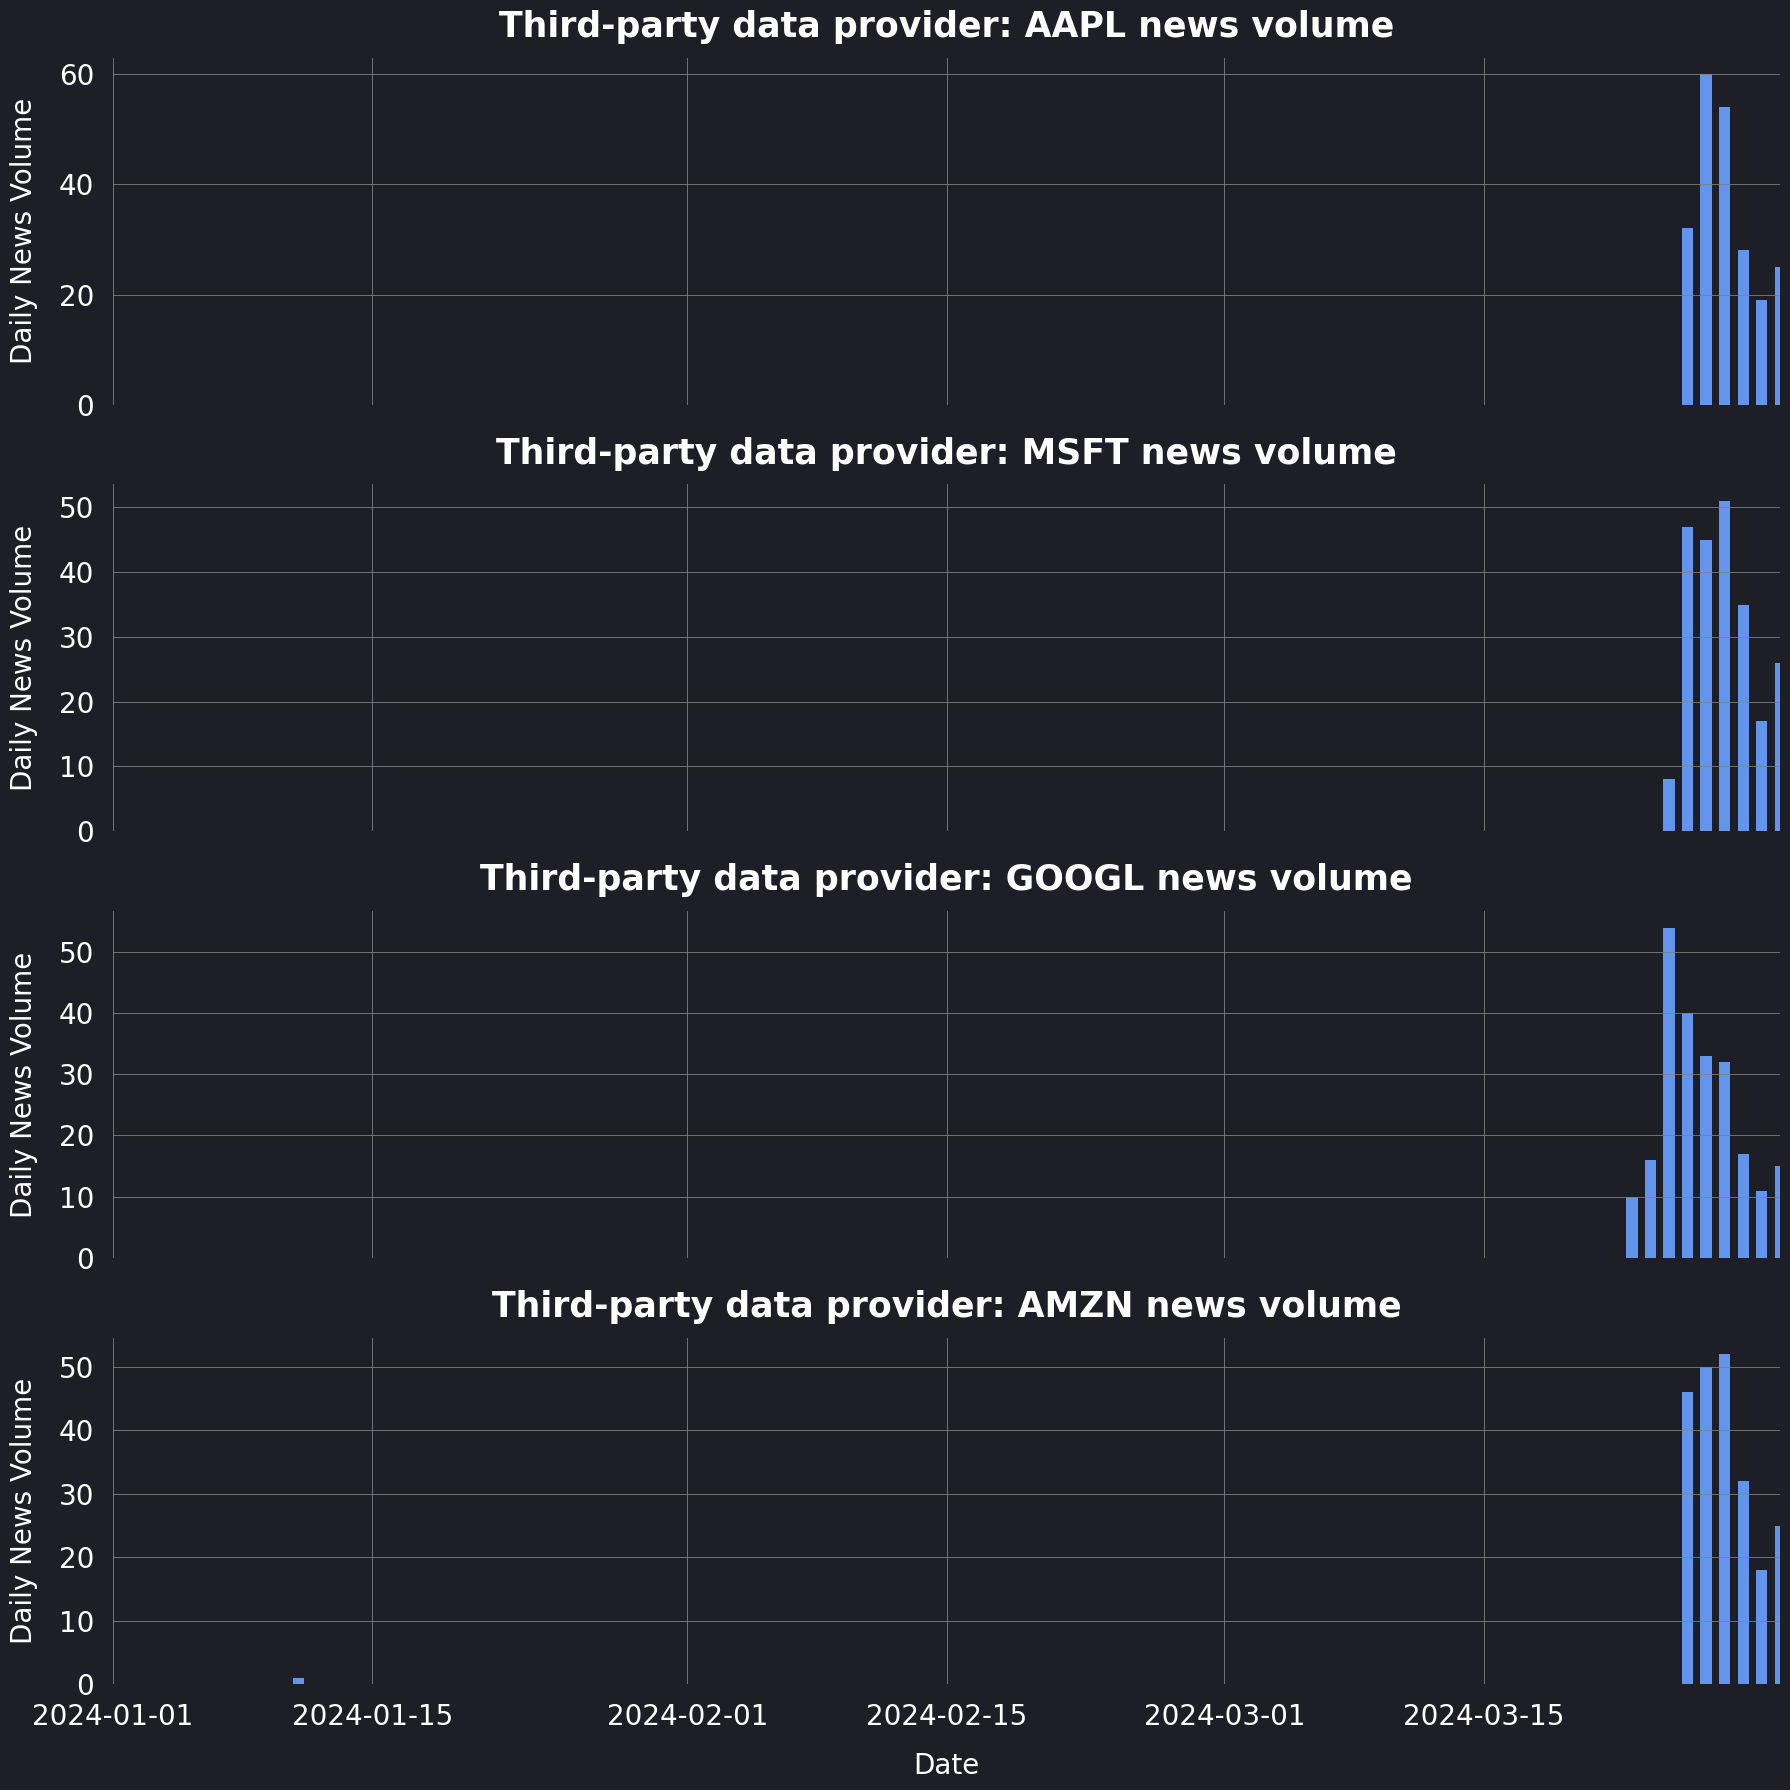

In [21]:
# Set the style of the plot
#plt.style.use("ggplot")

fig, axes = plt.subplots(4, sharex=True, figsize=(18, 18))

for index, ax in enumerate(axes):
    ax.set_title(f"Third-party data provider: {TICKERS[index]} news volume", pad=15, weight="bold", fontsize=25)
    if index == 3:
        ax.set_xlabel("Date", labelpad=15, fontsize=20)
    ax.set_ylabel("Daily News Volume", labelpad=15, fontsize=20)
    ax.bar(
        news_volume_dfs[index].index,
        news_volume_dfs[index]["News Volume"],
        width=0.6,
        color="cornflowerblue",
        zorder=1,
    )
    ax.set_xlim(
        [news_volume_dfs[index].index.min(), news_volume_dfs[index].index.max()]
    )
    ax.grid(True)
    ax.tick_params(bottom=False, left=False, pad=10, labelsize=20)

# Adjust layout for better spacing
fig.tight_layout()

plt.show()

Total articles
- Q3-2023: 922
- Q4-2023: 865 
- Q1-2024: 899

# The Guardian Opem platformm API
- https://open-platform.theguardian.com



Hence the Guardian does not support search by ticker, we will use the company name to search for news articles.

In [16]:
import requests
import time

# List of companies to fetch news for
companies = ["Apple", "Microsoft", "Google", "Amazon"]

# Contact me for the API key
THE_GUARDIAN_API_KEY = os.getenv("THE_GUARDIAN_API_KEY")

# Base URL
base_url = "https://content.guardianapis.com/search"

# Additional parameters
from_date = f"from-date={quarter['start']}"
to_date = f"to-date={quarter['end']}"
order_by = "order-by=oldest"
use_date = "use-date=published"
show_references = "show-references=reuters-stock-ric"
page_size = "page-size=200"
api_key = f"api-key={THE_GUARDIAN_API_KEY}"

# Store all articles in a dictionary, keyed by company name
all_articles = {}

try:
    for company in companies:
        query = f"q={company}"
        query_string = f"{from_date}&{to_date}&{order_by}&{use_date}&{show_references}&{page_size}&{query}&{api_key}"
        api = f"{base_url}?{query_string}"

        response = requests.get(api)
        response.raise_for_status()  # Raises HTTPError for bad responses
        json_response = response.json()

        pages = json_response["response"]["pages"]
        articles = json_response["response"]["results"]

        for page in range(2, pages + 1):
            time.sleep(1)  # Respectful delay to avoid rate limiting
            page_url = f"{api}&page={page}"
            response = requests.get(page_url)
            json_response = response.json()
            articles += json_response["response"]["results"]

        all_articles[company] = articles

except requests.exceptions.HTTPError as errh:
    print("Http Error:", errh)
except requests.exceptions.ConnectionError as errc:
    print("Error Connecting:", errc)
except requests.exceptions.Timeout as errt:
    print("Timeout Error:", errt)
except requests.exceptions.RequestException as e:
    raise SystemExit(e)

In [17]:
print(
    f"Total articles fetched: {sum([len(all_articles[company]) for company in all_articles])}"
)

Total articles fetched: 1192


In [18]:
# Get the news volume for each day
def get_news_volume_the_guardian(articles, ticker) -> List:
    """
    Get the news volume for each day from the Guardian.
    """

    news_volume = {}

    # Assuming quarter['start'] and quarter['end'] are defined elsewhere in your code
    date_range = pd.date_range(start=quarter["start"], end=quarter["end"], freq="D")
    df = pd.DataFrame(
        {"Date": pd.Series(dtype="object"), "News Volume": pd.Series(dtype="int")}
    )
    df["Date"] = date_range
    df = df.set_index("Date")

    # Iterate over each article
    for article in articles:
        # Convert the article's timestamp to a pandas Timestamp object
        date_obj = datetime.strptime(
            article["webPublicationDate"], "%Y-%m-%dT%H:%M:%SZ"
        )
        date = date_obj.strftime("%Y-%m-%d")

        if date in news_volume:
            news_volume[date] += 1
        else:
            news_volume[date] = 1

    # Update the DataFrame with the news volume
    for date in df.index:
        df.at[date, "News Volume"] = news_volume.get(date.strftime("%Y-%m-%d"), 0)

    print(f"TICKER: {ticker}")
    print(f"Articles counted {int(sum(df['News Volume'].values))}")

    for date, volume in news_volume.items():
        date_obj = datetime.strptime(date, "%Y-%m-%d")
        print(f"{date} [{volume}] {date_obj.strftime('%A')}")

    # Return the DataFrame of news volume
    return df


# Assuming all_articles and companies are defined elsewhere in your code
guardian_volumes = [
    get_news_volume_the_guardian(all_articles[company], company)
    for company in companies
]

TICKER: Apple
Articles counted 441
2024-01-01 [5] Monday
2024-01-02 [5] Tuesday
2024-01-03 [2] Wednesday
2024-01-04 [3] Thursday
2024-01-05 [5] Friday
2024-01-06 [3] Saturday
2024-01-07 [3] Sunday
2024-01-08 [2] Monday
2024-01-09 [4] Tuesday
2024-01-10 [4] Wednesday
2024-01-11 [5] Thursday
2024-01-12 [8] Friday
2024-01-13 [4] Saturday
2024-01-14 [3] Sunday
2024-01-15 [3] Monday
2024-01-16 [8] Tuesday
2024-01-17 [8] Wednesday
2024-01-18 [6] Thursday
2024-01-19 [7] Friday
2024-01-20 [3] Saturday
2024-01-21 [6] Sunday
2024-01-22 [2] Monday
2024-01-23 [5] Tuesday
2024-01-24 [6] Wednesday
2024-01-25 [9] Thursday
2024-01-26 [1] Friday
2024-01-27 [1] Saturday
2024-01-28 [6] Sunday
2024-01-29 [2] Monday
2024-01-30 [7] Tuesday
2024-01-31 [5] Wednesday
2024-02-01 [7] Thursday
2024-02-02 [4] Friday
2024-02-03 [2] Saturday
2024-02-04 [4] Sunday
2024-02-05 [5] Monday
2024-02-06 [7] Tuesday
2024-02-07 [3] Wednesday
2024-02-08 [5] Thursday
2024-02-09 [3] Friday
2024-02-10 [4] Saturday
2024-02-11 [4] 

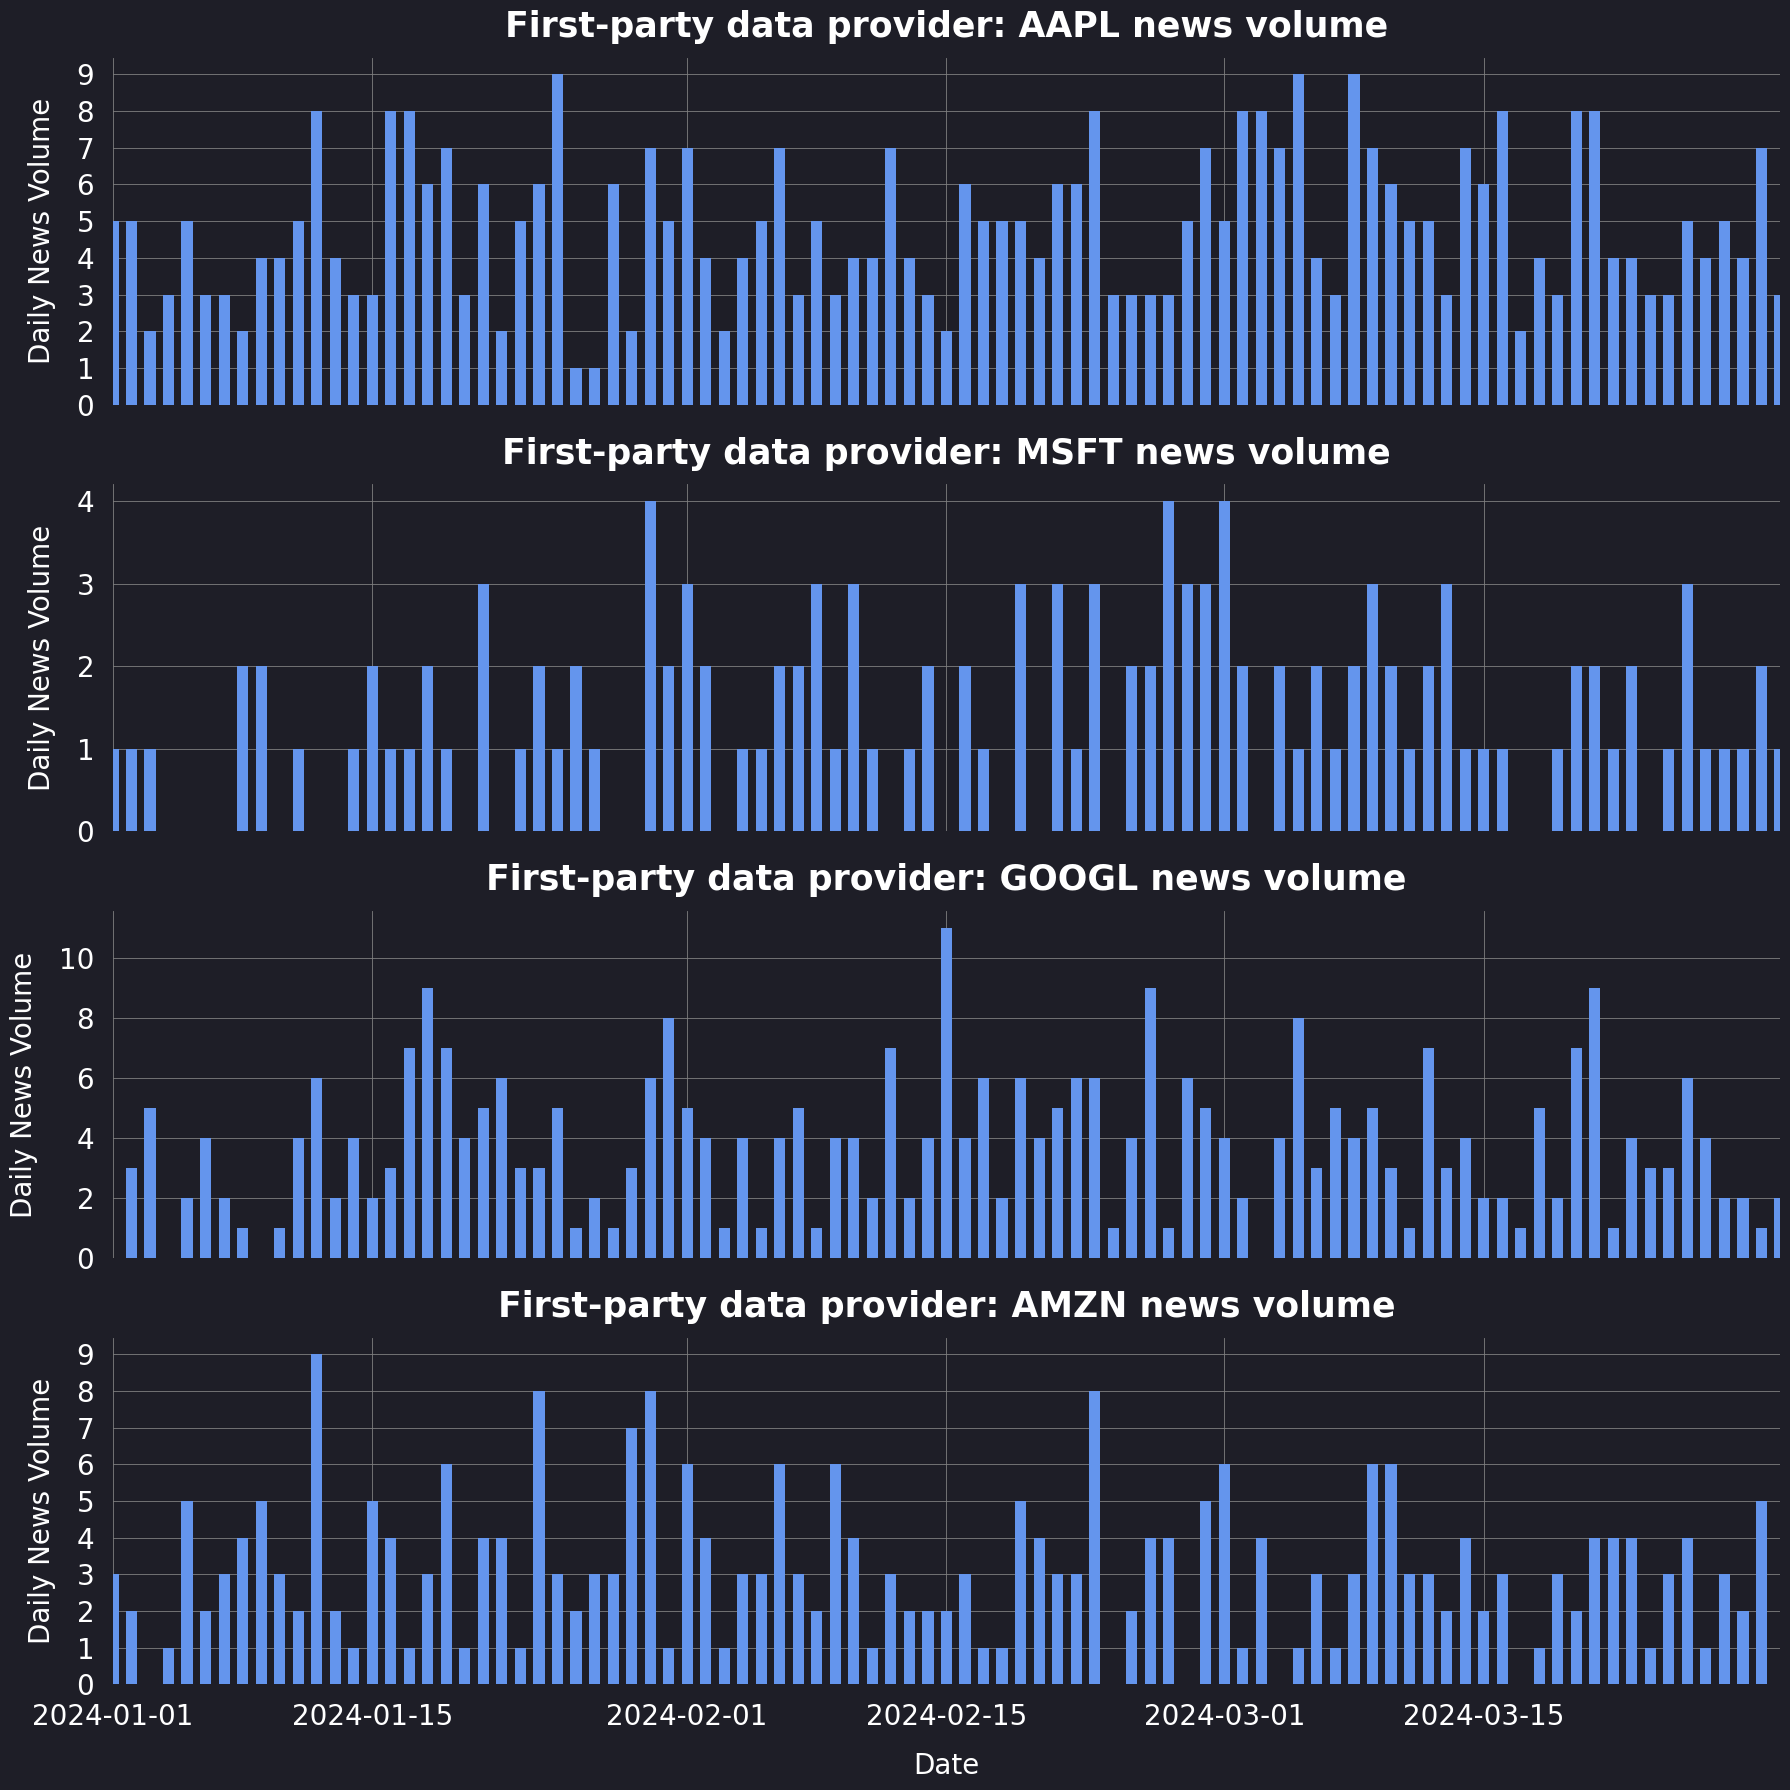

In [22]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# Create subplots for each ticker
fig, axes = plt.subplots(len(guardian_volumes), sharex=True, figsize=(18, 18))

for index, ax in enumerate(axes):
    ax.set_title(f"First-party data provider: {TICKERS[index]} news volume", pad=15, weight="bold", fontsize=25)
    if (
        index == len(guardian_volumes) - 1
    ):  # Adjust this condition based on the number of tickers
        ax.set_xlabel("Date", labelpad=15, fontsize=20)
    ax.set_ylabel("Daily News Volume", labelpad=15, fontsize=20)

    # Plot the 'News Volume' for each ticker
    ax.bar(
        guardian_volumes[index].index,
        guardian_volumes[index]["News Volume"].astype(int),
        width=0.6,
        color="cornflowerblue",
        zorder=2,
    )
    ax.set_xlim(
        [guardian_volumes[index].index.min(), guardian_volumes[index].index.max()]
    )
    ax.grid(True, which="both", zorder=0)
    ax.tick_params(bottom=False, left=False)
    ax.yaxis.set_major_locator(
        MaxNLocator(integer=True)
    )  # Ensure y-axis has only integer values
    ax.tick_params(bottom=False, left=False, pad=10, labelsize=20)

fig.tight_layout()

Total articles
- Q3-2023: 1192
- Q4-2023: 1263 
- Q1-2024: 1265